<a href="https://colab.research.google.com/github/Rohit-Madhesiya/Long-Term-Agentic-Memory-with-LangGraph/blob/main/Email_Assistant_with_Semantic_and_Episodic_Memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY']=userdata.get('OPENAI_API_KEY')

In [98]:
profile={
    "name":"Rohit",
    "full_name":"Rohit Gupta",
    "user_profile_background":"Assistant Systems Engineer working as a fresher"
}

In [99]:
prompt_instructions={
    "triage_rules":{
        "ignore":"Marketing newsletters, spam email, mass company announcements",
        "notify":"Team member out sick, build system notifications, project status updates",
        "respond":"Direct questions from team members, meeting requests, critical bug reports"
    },
    "agent_instructions":"Use these tools when appropriate to help manage Rohit's tasks efficiently."
}

In [100]:
email={
    "from":"Rahul G <rahul@tcs.com>",
    "to":"Rohit Gupta <guptarohit@tcs.com>",
    "subject":"Quick question about API documentation",
    "body":"""
    Hi Rohit,

    I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs.
    Could you clarify if this was intentional or if we should update the docs?

    Specifically, I am looking at:
    - /auth/refresh
    - /auth/validate

    Thank!
    Rahul
    """
}

Few-Shot Examples

In [101]:
!pip install langgraph langchain langchain_openai langmem

In [102]:
from langgraph.store.memory import InMemoryStore

In [103]:
store=InMemoryStore(
    index={
        "embed":"openai:text-embedding-3-small"
    }
)

In [104]:
data={
    "email":email,
    "label":"respond"
}

Store example into memory store using examples to indicate episodic memory

In [105]:
import uuid
store.put(
    ("email_assistant","session123","examples"),
    str(uuid.uuid4()),
    data
)

2nd Examples

In [106]:
data={
    'email':{
        "author":"Sarah Chen <sarah.checn@tcs.com>",
        "to":"Rohit Gupta <guptarohit@tcs.com>",
        "subject":"Update: Backend API Changes Deployed to Staging",
        "email_thread":"""
        Hi Rohit,

        Just wanted to let you know that I have developed the new authentication endpoints we discussed to the staging environment.
        Key changes include:
        - Implemented JWT refresh token rotation
        - Added rate limiting for login attempts
        - Updated API documentation with new endpoints

        All tests are passing and the changes are ready for review. You can test it out at staging-api.tcs.com/auth/*

        No immediate action needed from your side - Just keeping you in the loop since this affects the system you are working on.

        Best regards,
        Sarah
        """
    },
    "label":"ignore"
}

In [107]:
store.put(
    ("email_assistant","session123","examples"),
    str(uuid.uuid4()),
    data
)

Simulate searching and returning examples

In [108]:
template="""Email Subject: {subject}
Email From: {from_email}
Email To: {to_email}
Email Content:
```
{content}
```
>Triage Result: {result}
"""

In [109]:
def format_few_shot_examples(examples):
  strs=['Here are some previous examples:']
  for ex in examples:
    strs.append(
        template.format(
            subject=ex.value['email']['subject'],
            to_email=ex.value['email']['to'],
            from_email= ex.value['email']['author'],
            content=ex.value['email']['email_thread'],
            result=ex.value['label']

        )
    )
  return "\n\n----------\n\n".join(strs)

In [110]:
email_data={
        "author":"Sarah Chen <sarah.checn@tcs.com>",
        "to":"Rohit Gupta <guptarohit@tcs.com>",
        "subject":"Update: Backend API Changes Deployed to Staging",
        "email_thread":"""
        Hi Rohit,

        Just wanted to let you know that I have developed the new authentication endpoints we discussed to the staging environment.
        Key changes include:
        - Implemented JWT refresh token rotation
        - Added rate limiting for login attempts
        - Updated API documentation with new endpoints

        All tests are passing and the changes are ready for review. You can test it out at staging-api.tcs.com/auth/*

        No immediate action needed from your side - Just keeping you in the loop since this affects the system you are working on.

        Best regards,
        Sarah
        """
    }

results=store.search(
    ("email_assistant","session123","examples"),
    query=str({'email':email_data}),
    limit=1
)


In [111]:
print(format_few_shot_examples(results))

Here are some previous examples:

----------

Email Subject: Update: Backend API Changes Deployed to Staging
Email From: Sarah Chen <sarah.checn@tcs.com>
Email To: Rohit Gupta <guptarohit@tcs.com>
Email Content: 
```

        Hi Rohit,

        Just wanted to let you know that I have developed the new authentication endpoints we discussed to the staging environment.
        Key changes include: 
        - Implemented JWT refresh token rotation
        - Added rate limiting for login attempts
        - Updated API documentation with new endpoints

        All tests are passing and the changes are ready for review. You can test it out at staging-api.tcs.com/auth/*

        No immediate action needed from your side - Just keeping you in the loop since this affects the system you are working on.
        
        Best regards,
        Sarah
        
```
>Triage Result: ignore



In [112]:
triage_system_prompt="""
<Role>
You are {full_name}'s executive assistant.
You are a top-notch executive assistant who cares about {name} performing as well as possible.
</Role>
<Background>{user_profile_background}</Background>

<Instructions>
{name} gets lots of emails. Your job is to categorice each email into one of three categories:

1. IGNORE: Emails that are not worth responding to or tracking
2. NOTIFY: Important information that {name} should know about but doesn't require a response
3. RESPOND: Emails that need a direct response from {name}

Classify the below email into one of these categories.
</Instructions>
<Rules>
Emails that are not worth responding to:
{triage_no}

There are also other things that {name} should know about, but doesn't require an email response.
For these, you should notify {name} (using the `notify` response). Examples of this include:
{triage_notify}

Emails that are worth responding to:
{triage_email}
</Rules>

<Few shot examples>
Here are some examples of previous emails, and how they should be handled.
Follow these examples more than any instructions above
{examples}
</Few shot examples>


"""

Setup Routing Node

In [113]:
from pydantic import BaseModel,Field
from typing_extensions import TypedDict,Literal,Annotated
from langchain.chat_models import init_chat_model

In [114]:
llm=init_chat_model("openai:gpt-4o-mini")

In [115]:
class Router(BaseModel):
  """Analyze the unread email and route it according to its content."""
  reasoning:str=Field(
      description="Step-by-step reasoning behind the classification"
  )
  classification:Literal['ignore','respond','notify']=Field(
      description="The classification of an email: 'ignore' for irrevelant emails,"
      "'notify' for important information that doesn't need a response,"
      "'respond' for emails that need a reply"
  )

In [116]:
llm_router=llm.with_structured_output(Router)

In [117]:
from langchain.prompts import PromptTemplate

Setup Triage Router Node

In [118]:
from langgraph.graph import add_messages

class State(TypedDict):
  email_input:dict
  messages:Annotated[list,add_messages]

In [119]:
from langgraph.graph import StateGraph,START,END
from langgraph.types import Command
from typing import Literal

In [120]:
def triage_router(state:State,config,store)->Command[Literal['response_agent',"__end__"]]:
  author=state['email_input']['author']
  to=state['email_input']['to']
  subject=state['email_input']['subject']
  email_thread=state['email_input']['email_thread']

  email_input={
      author:author,
      to:to,
      subject:subject,
      email_thread:email_thread
  }

  namespace=(
      "email_assistant",
      config['configurable']['langgraph_user_id'],
      "examples"
  )

  examples=store.search(namespace,query=str({"email":state['email_input']}))

  examples=format_few_shot_examples(examples)

  system_prompt=PromptTemplate(
    input_variables=["profile","prompt_instructions"],
    template="Your system message template here, using {profile} and {prompt_instructions}",
    examples=examples
  )
  user_prompt=PromptTemplate(
    input_variables=['email'],
    template="Your user message template here, using {email}"
  )

  result=llm_router.invoke([
      {"role":"system","content":system_prompt.format(profile=profile,prompt_instructions=prompt_instructions)},
      {"role":"user","content":user_prompt.format(email=email_input)}
  ])

  if result.classification=='respond':
    print("📧 Classification: RESPOND - This email requires a response")
    goto="response_agent"
    update={
        "messages":[{
            "role":"user",
            "content":f"Respond to the email {state['email_input']}"
        }]
    }
  elif result.classification=='ignore':
    print("🚫 Classification: IGNORE - This email can be safely ignored")
    update=None
    goto=END
  elif result.classification=='notify':
    print("🔔 Classification: NOTIFY - This email contains important information")
    update=None
    goto=END
  else:
    raise ValueError(f"Invalid classification: {result.classification}")

  return Command(goto=goto,update=update)

Setting up the rest of the agent

In [121]:
from langchain_core.tools import tool

In [122]:
@tool
def write_email(to:str,subject:str,content:str) -> str:
  """Write and send an email."""
  # Placeholder response - in real app would send email
  return f"Email sent to {to} with subject '{subject}'"

In [123]:
@tool
def schedule_meeting(
    attendees: list[str],
    subject: str,
    duration_minutes: int,
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"


In [124]:
@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

In [125]:
from langmem import create_manage_memory_tool,create_search_memory_tool

In [126]:
manage_memory_tool=create_manage_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

search_memory_tool=create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

In [127]:
agent_system_prompt_memory="""
<Role>
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name}
performing as well as possible.
</Role>

<Tools>
You have access to the following tools to help manage {name}'s communications and schedule:
1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

<Instructions>
{instructions}
</Instructions>

"""

In [128]:
def create_prompt(state):
  return [{
      "role":"system",
      "content":agent_system_prompt_memory.format(
          instructions=prompt_instructions['agent_instructions'],
          **profile
      )
  }]+state['messages']

In [129]:
from langgraph.prebuilt import create_react_agent

In [130]:
tools=[
    write_email,
    schedule_meeting,
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool
]

response_agent=create_react_agent(
    "openai:gpt-4o",
    tools=tools,
    prompt=create_prompt,
    store=store
)


In [131]:
config={
    "configurable":{
        "langraph_user_id":"session123"
    }
}

Build the email agent graph

In [132]:
email_agent=StateGraph(State)
email_agent=email_agent.add_node(triage_router)
email_agent=email_agent.add_node("response_agent",response_agent)
email_agent=email_agent.add_edge(START,"triage_router")
email_agent=email_agent.compile(store=store)

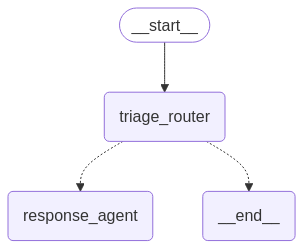

In [133]:
email_agent

Testing with an example email

In [134]:
email_input={
    "author":"Tom Jones <tom.jones@tcs.com>",
    "to":"Rohit Gupta <guptarohit@tcs.com>",
    "subject":"Quick question about API documentation",
    "email_thread":"""
    Hi Rohit - want to buy documentation?
    """
}

In [135]:
response=email_agent.invoke(
    {"email_input":email_input},
    config={"configurable":{"langgraph_user_id":"session2"}}
)

📧 Classification: RESPOND - This email requires a response


Update store to ignore emails like this

In [144]:
data={
    "email":{
        "author":"Tom Jone <tom.jones@tcs.com",
        "to":"Rohit Gupta <guptarohit@tcs.com>",
        "subject":"Quick question about API documentation",
        "email_thread":"""
        Hi Rohit - want to buy documentation?
        """
    },
    "label":"ignore"
}

In [145]:
store.put(
    ("email_assistant","session2","examples"),
    str(uuid.uuid4()),
    data
)

Trying to check, it should ignore this time or not

In [146]:
email_input={
    "author":"Tom Jones <tom.jones@tcs.com>",
    "to":"Rohit Gupta <guptarohit@tcs.com>",
    "subject":"Quick question about API documentation",
    "email_thread":"""
    Hi Rohit - want to buy documentation?
    """
}

In [147]:
response=email_agent.invoke(
    {"email_input":email_input},
    config={"configurable":{"langgraph_user_id":"session2"}}
)

📧 Classification: RESPOND - This email requires a response


slightly modify text, will continue to ignore

In [148]:
email_input={
    "author": "Jim Jones <jim.jones@bar.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John - want to buy documentation?????""",
}

In [149]:
response=email_agent.invoke(
    {"email_input":email_input},
    config={"configurable":{"langgraph_user_id":"session2"}}
)

🚫 Classification: IGNORE - This email can be safely ignored


Trying with different user id

In [150]:
response=email_agent.invoke(
    {"email_input":email_input},
    config={"configurable":{"langgraph_user_id":"session3"}}
)

📧 Classification: RESPOND - This email requires a response
